In [11]:
from utils import initialize_patient, Params
from uva_padova_torch import observe_blood_glucose, observe_subcutaneous_glucose, uva_padova_2008_dynamics

import torch
params, unused_params, init_state = initialize_patient("adult#001", to_tensors=True)

Loading patient adult#001


In [12]:
def square_controls(widths, events, t):
    """Compute a square wave function with the same width for each bump

    Each event is an array of [event_time, amplitude].

    Args:
        events (torch.Tensor): (T_e, 2) tensor of T_e events or (N, T_e, 2) tensor of events.
            If (N, T_e, 2), then each `t` has its own event  sequence
        t (torch.Tensor): (N,) tensor of times.
        width (torch.Tensor): duration of each event; scalar, (T_e,) or (N, T_e) tensor

    Example:
        width = torch.tensor(15.0)
        events = torch.tensor([
            [0.0, 1.0],
            [30.0, 3.0],
            [45.0, 7.0],
        ])
        t = torch.linspace(0, 60, 1000)
        u = square_controls(width, events, t)
    """
    N, = t.shape
    T_e, D = events.shape[-2:]
    assert D == 2
    events = events.broadcast_to((N, T_e, D))
    widths = widths.broadcast_to((N, T_e))

    timestamps, amplitudes = events.unbind(-1) # (N, T_e), (N, T_e)

    t_since = t[:, None] - timestamps # (N, T_e)
    relevant = t_since >= 0 # (N, T_e)
    t_since = torch.where(relevant, t_since, torch.zeros_like(t_since)) # (N, T_e)
    u = amplitudes * relevant * (t_since < widths) # (N, T_e)
    u = u.sum(-1) # (N,)
    return u

In [13]:
# generate meal events
import numpy as np
from scipy.stats import truncnorm

def generate_meals(seed=0, num_days=1, bw=60.0):
    # bodyweight bw in kg
    # each row of meals is [time, amount] in minutes and grams
    rng = np.random.RandomState(seed)
    meals = []
    for i in range(num_days):
        new_meals = generate_meals_one_day(rng, bw)
        new_meals[:, 0] += i * 24 * 60
        meals.append(new_meals)
    return np.concatenate(meals)

def generate_meals_one_day(rng, bw: float):
    meals = []

    # Probability of taking each meal
    # [breakfast, snack1, lunch, snack2, dinner, snack3]
    prob = np.array([1.0, 0.25, 1.0, 0.25, 1.0, 0.25])
    time_lb = np.array([5, 9, 10, 14, 16, 20]) * 60.
    time_ub = np.array([9, 10, 14, 16, 20, 23]) * 60.
    time_mu = np.array([7, 9.5, 12, 15, 18, 21.5]) * 60.
    time_sigma = np.array([60, 30, 60, 30, 60, 30])
    amount_mu = np.array([0.7, 0.15, 1.1, 0.15, 1.25, 0.15]) * bw
    amount_sigma = np.array([0.15, 0.05, 0.15, 0.05, 0.15, 0.05]) * bw
    #amount_mu = [45, 10, 70, 10, 80, 10]
    #amount_sigma = [10, 5, 10, 5, 10, 5]

    for p, tlb, tub, tbar, tsd, mbar, msd in zip(prob, time_lb, time_ub,
                                                 time_mu, time_sigma,
                                                 amount_mu, amount_sigma):
        if rng.rand() < p:
            tmeal = np.round(
                truncnorm.rvs(a=(tlb - tbar) / tsd,
                              b=(tub - tbar) / tsd,
                              loc=tbar,
                              scale=tsd,
                              random_state=rng),
                )
            amount = round(max(rng.normal(mbar, msd), 0.))
            meal = np.array([tmeal, amount])  # time in minutes, amount in grams
            meals.append(meal)
    meals = np.stack(meals)
    return meals

def generate_insulin_events(meals, icr, num_days):
    # Assumes meals are in grams, basal is in units, icr is in grams per unit, and bw is in kg
    bolus_times = meals[:, 0] - 5. # TODO: bolus a few minutes before meals
    bolus_dose = meals[:, 1] / icr  # units: IU
    insulin_times = np.concatenate([bolus_times])
    insulin_dose = np.concatenate([bolus_dose])

    # sort by time
    idx = np.argsort(insulin_times)
    insulin_times = insulin_times[idx]
    insulin_dose = insulin_dose[idx]
    insulin_events = np.stack([insulin_times, insulin_dose], axis=1)
    return insulin_events

def generate_meals_and_insulin_events(icr, bw, num_days, seed):
    meals = generate_meals(seed, num_days, bw)
    insulin_events = generate_insulin_events(meals, icr=icr, num_days=num_days)
    return meals, insulin_events

In [14]:
from functools import partial


def make_controller_params(meals, doses, bw, dt, eating_rate=5.0):
    """
    Assumes:
    meal times in minutes, meal amounts in g, insulin doses in U, bw in kg
    eating_rate in g/min
    dt in minutes
    """
    # compute meal duration
    meal_widths = meals[:, 1] / eating_rate  # minutes
    meal_times = meals[:, 0]  # time in minutes
    # make eating rate the amplitude of our meal controller
    amplitude = eating_rate * np.ones_like(meals[:, 1])  # g/min
    # convert to mg/min
    amplitude = amplitude * 1000.0
    meal_events = np.stack([meal_times, amplitude], axis=1)

    insulin_widths = dt * 2 # mins; assume injection time is constant 
    insulin_times = doses[:, 0]  # time in minutes
    # convert U to pmols/kg
    amplitude = doses[:, 1] * 6000 / bw
    # convert to pmols/kg/min
    amplitude = amplitude / insulin_widths
    insulin_events = np.stack([insulin_times, amplitude], axis=1)

    meal_widths = torch.tensor(meal_widths, dtype=torch.float)
    meal_events = torch.tensor(meal_events, dtype=torch.float)
    insulin_widths = torch.tensor(insulin_widths, dtype=torch.float)
    insulin_events = torch.tensor(insulin_events, dtype=torch.float)

    meal_controller = partial(square_controls, meal_widths, meal_events) 
    insulin_controller = partial(square_controls, insulin_widths, insulin_events)
    return meal_controller, insulin_controller

In [20]:
t0 = 0.
num_days = 1
t1 = 60. * 24 * num_days # 24 hours in minutes
dt = 1.0   # IMPORANT: this can't be too large or else the integration will diverge (ex when t=5.)
T = int((t1 - t0) / dt) + 1
state = init_state.clone()
states = [state]
others = []
icr = unused_params["CR"] 
cf = unused_params["CF"] 
target_bg = 140.

basal_rate = unused_params["u2ss"] # u2ss is in pmols/kg/min

meals, doses = generate_meals_and_insulin_events(icr=icr, bw=params.BW.item(), num_days=num_days, seed=0)

u_m, u_i = make_controller_params(meals, doses, bw=params.BW, dt=dt)
for i in range(T - 1):
    #print("stepping", i)
    t = t0 + dt * i
    t = torch.tensor([t])
    carbs = u_m(t)[0]
    bg = observe_blood_glucose(params, state)

    cr_dose = u_i(t)
    cf_dose = (cr_dose > 0) * (bg - target_bg) / cf
    dose = cr_dose + cf_dose
    insulin = dose[0] + basal_rate
    insulin = torch.clamp(insulin, min=0.)

    with torch.no_grad():
        dstate_dt, other = uva_padova_2008_dynamics(params, t, state, carbs, insulin)
        state = state + dstate_dt * dt
    states.append(state)
    others.append(other)
states = torch.stack(states, dim=0)
others = {k: torch.stack([o[k] for o in others], dim=0) for k in others[0]}

In [21]:
dq_sto1, dq_sto2, dq_gut, dG_p, dG_t, dI_p, dX, dI_1, dI_d, dI_l, dI_sc1, dI_sc2, dGs = states.T

[Text(0, 0.5, 'dGs')]

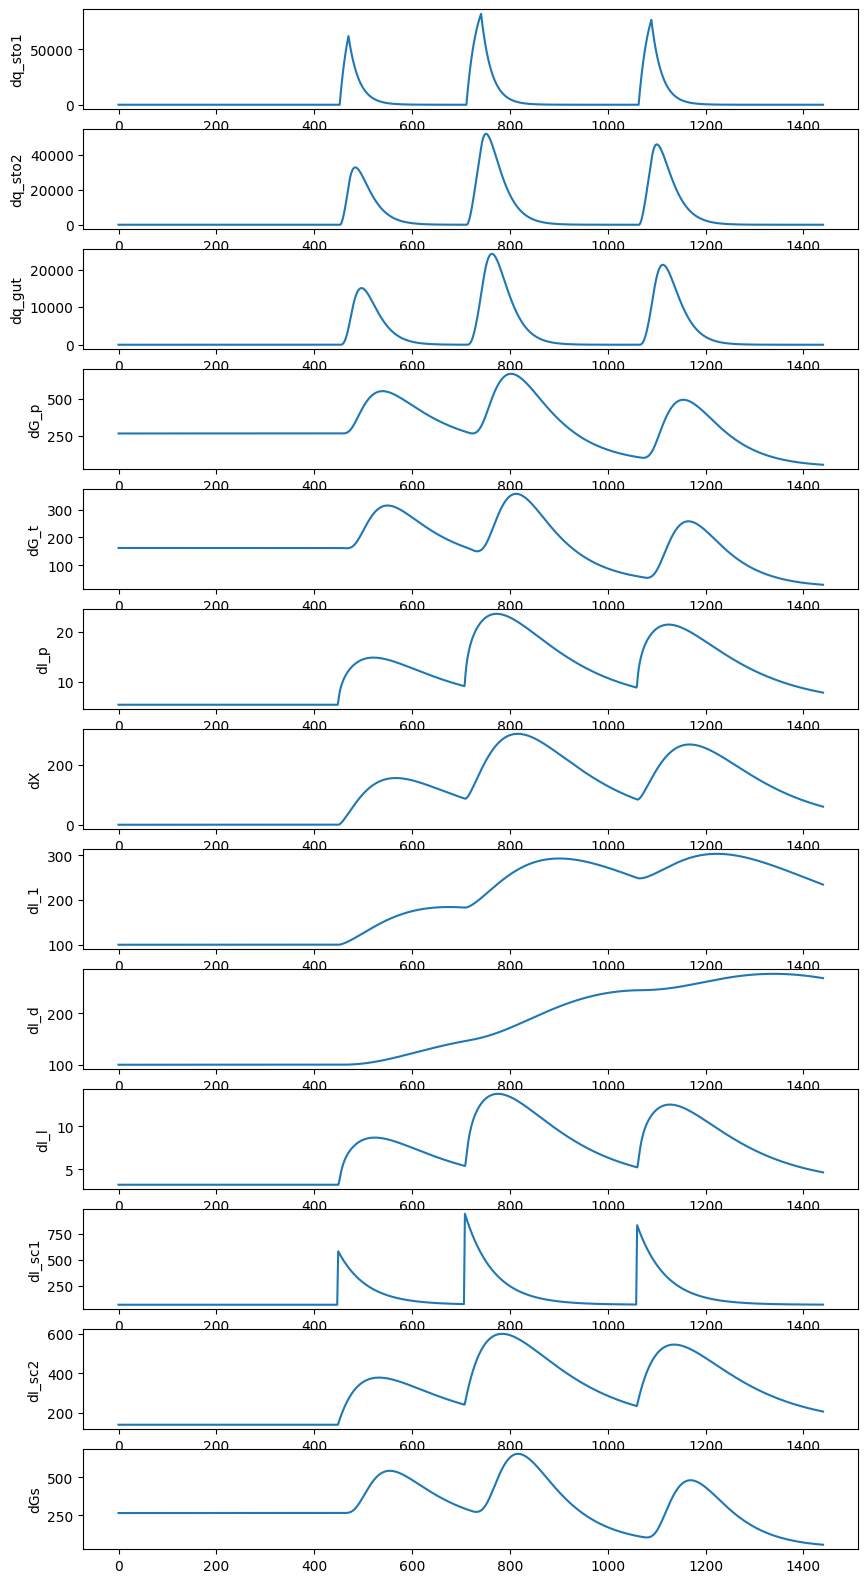

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(13, 1, figsize=(10, 20))
ax[0].plot(dq_sto1)
ax[0].set(ylabel="dq_sto1")
ax[1].plot(dq_sto2)
ax[1].set(ylabel="dq_sto2")
ax[2].plot(dq_gut)
ax[2].set(ylabel="dq_gut")
ax[3].plot(dG_p)
ax[3].set(ylabel="dG_p")
ax[4].plot(dG_t)
ax[4].set(ylabel="dG_t")
ax[5].plot(dI_p)
ax[5].set(ylabel="dI_p")
ax[6].plot(dX)
ax[6].set(ylabel="dX")
ax[7].plot(dI_1)
ax[7].set(ylabel="dI_1")
ax[8].plot(dI_d)
ax[8].set(ylabel="dI_d")
ax[9].plot(dI_l)
ax[9].set(ylabel="dI_l")
ax[10].plot(dI_sc1)
ax[10].set(ylabel="dI_sc1")
ax[11].plot(dI_sc2)
ax[11].set(ylabel="dI_sc2")
ax[12].plot(dGs)
ax[12].set(ylabel="dGs")
#ax[13].plot(others["Ra"][:, 0])
#ax[13].set(ylabel="Ra")
#ax[13].plot(others["Ra_I"][:, 0])
#ax[13].set(ylabel="Ra_I")
#ax[13].plot(others["Uid"][:, 0])
#ax[13].set(ylabel="Uid")

[(0.0, 300.0)]

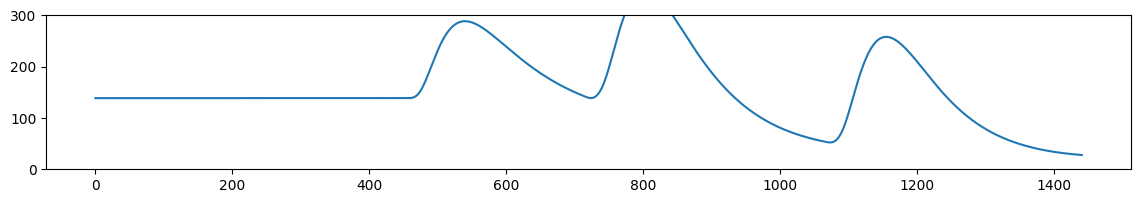

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(14, 2))
G = observe_blood_glucose(params, states)
ax.plot(G)
ax.set(ylim=[0, 300])

[(0.0, 300.0)]

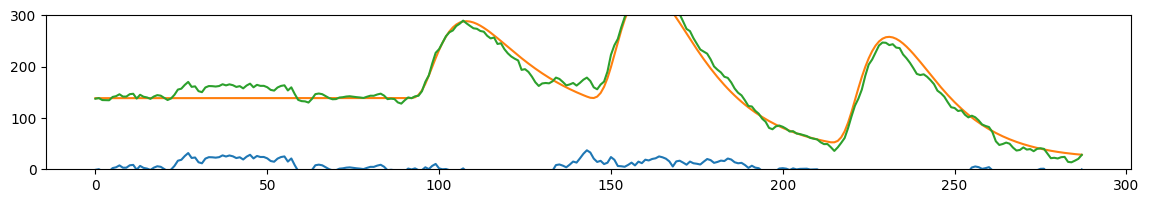

In [24]:
noise = torch.randn(len(G) // 5) * 5 
for i in range(1, len(noise)):
    noise[i] = noise[i] + 0.9 * noise[i - 1]

fig, ax = plt.subplots(1, 1, figsize=(14, 2))

noisy_G = noise.clone()
G_subsampled = noise.clone()
for i in range(len(noisy_G)):
    noisy_G[i] = noisy_G[i] + G[i * 5]
    G_subsampled[i] = G[i * 5]

ax.plot(noise)
ax.plot(G_subsampled)
ax.plot(noisy_G)
ax.set(ylim=[0, 300])